In [1]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
from imp import reload
from typing import List
import os
import pickle
import pandas as pd
import numpy as np

from skimage.transform import resize

from data_utils import DataHandler
import evaluate
import text_retrieval
import image_features
import image_utils
import bg_masks
import similarities
import detect_textbox
import histogram_processing
import visualizer

N_PROCESS = 10

/var/folders/zj/hvgbgg5j4qdc72qhxpzc2x2h0000gn/T/ipykernel_12499/2302345554.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
data_handler = DataHandler()

# Load images:
db, db_files = data_handler.load_images(
    folder="../data/BBDD/", extension=".jpg", desc="Loading BBDD Data...")
qst1_w5, qst1_w5_files = data_handler.load_images(
    folder="../data/Test/qst1_w5_denoised/", extension=".jpg", desc="Loading qst1_w5 Data...")

# Load text:
db_text = data_handler.load_text(
    folder="../data/BBDD/", extension=".txt", desc="Loading BBDD Text data...")


Initialized DataHandler with 2 processes


Loading BBDD Data...:  30%|███       | 87/287 [00:01<00:03, 56.58it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Loading BBDD Data...: 100%|██████████| 287/287 [00:05<00:00, 49.54it/s]


../data/BBDD/ read: 287 images


Loading qst1_w5 Data...: 100%|██████████| 50/50 [00:00<00:00, 124.89it/s]


../data/Test/qst1_w5_denoised/ read: 50 images


Loading BBDD Text data...: 100%|██████████| 287/287 [00:00<00:00, 18315.18it/s]

../data/BBDD/ read: 287 images


In [3]:
# get de minimum shape of the images in qst1_w5
minimum_x = 100000
minimum_y = 100000
for idx, img in enumerate(qst1_w5):
    if minimum_x > img.shape[0]:
        minimum_x = img.shape[0]
    if minimum_y > img.shape[1]:
        minimum_y = img.shape[1]

print("minimum_x: ", minimum_x)
print("minimum_y: ", minimum_y)

minimum_x:  506
minimum_y:  362


In [4]:
# get de minimum shape of the images in db
minimum_x = 100000
minimum_y = 100000
for idx, img in enumerate(db):
    if minimum_x > img.shape[0]:
        minimum_x = img.shape[0]
    if minimum_y > img.shape[1]:
        minimum_y = img.shape[1]

print("minimum_x: ", minimum_x)
print("minimum_y: ", minimum_y)

minimum_x:  242
minimum_y:  235


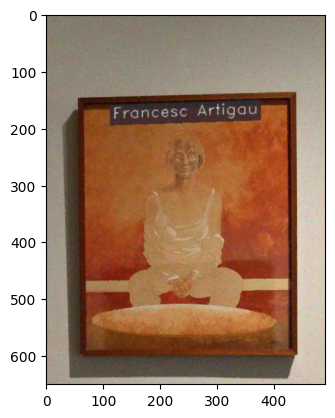

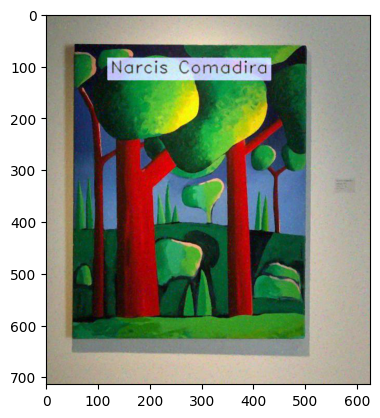

In [5]:
from skimage.filters import unsharp_mask
from skimage.exposure import equalize_hist
from skimage.exposure import adjust_gamma, equalize_adapthist
import cv2
from skimage.filters import median
from skimage.morphology import disk


# qst1_w5 = [adjust_gamma(img, gamma=2, gain=0.6) for img in qst1_w5]
plt.imshow(qst1_w5[26],)
plt.show()
plt.imshow(qst1_w5[29],)
plt.show()

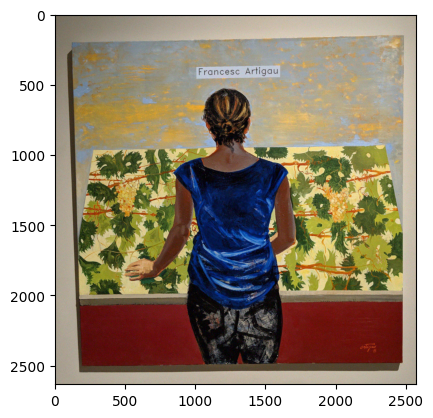

In [6]:
plt.imshow(qst1_w5[25])

### Generate masks (try new methods)

In [7]:
reload(bg_masks)
res = bg_masks.generate_masks_multiple(
    qst1_w5,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with up to three components...",
    image_files=qst1_w5_files,
    output_dir='../data/morphology_masks_qst1_w5/',
    method='mask_multiple_n',    # new morphology method
)

Generating masks with up to three components...: 100%|██████████| 50/50 [00:01<00:00, 31.88it/s]


### Load saved masks

In [10]:
# load background masks
masks_gen_morphology_qst1_w5, masks_gen_morphology_qst1_w5_files = data_handler.load_images(
    folder=f"../data/morphology_masks_qst1_w5/",
    extension=".png",
    desc=f"Loading background masks for QSD1-W5..."
)

Loading background masks for QSD1-W5...: 100%|██████████| 50/50 [00:00<00:00, 317.19it/s]


../data/morphology_masks_qst1_w5/ read: 50 images


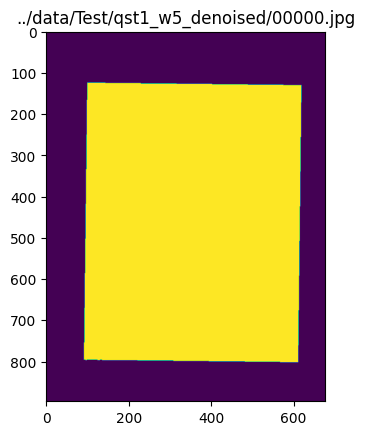

In [11]:
plt.imshow(masks_gen_morphology_qst1_w5[4])
plt.title(qst1_w5_files[0])
plt.show()


### Save angle and bboxes "*/frames.pkl"

In [12]:
reload(bg_masks)
results = bg_masks.get_angle_bboxes_multiple(
    masks=masks_gen_morphology_qst1_w5,
    mssg="Computing angle and bboxes for each mask...",
    output_dir=f"../data/morphology_masks_qst1_w5/"
)

Computing angle and bboxes for each mask...: 100%|██████████| 50/50 [00:05<00:00,  9.15it/s]

Saved results to ../data/morphology_masks_qst1_w5/frames.pkl


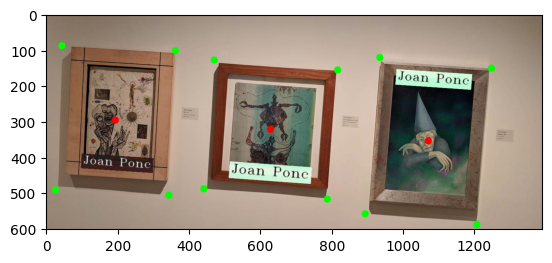

In [13]:
reload(bg_masks)
lala = bg_masks.draw_mask_points_on_image(qst1_w5[8], masks_gen_morphology_qst1_w5[8])
plt.imshow(lala)

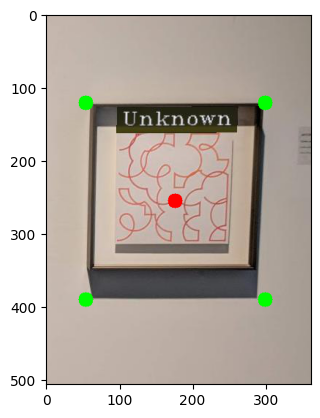

In [14]:
lala = bg_masks.draw_mask_points_on_image(qst1_w5[10], masks_gen_morphology_qst1_w5[10])
plt.imshow(lala)

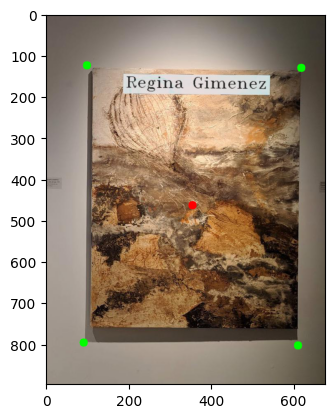

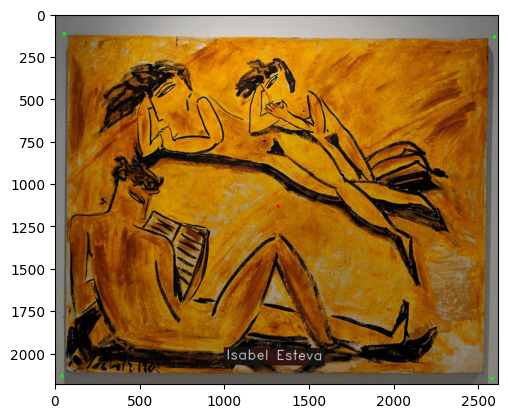

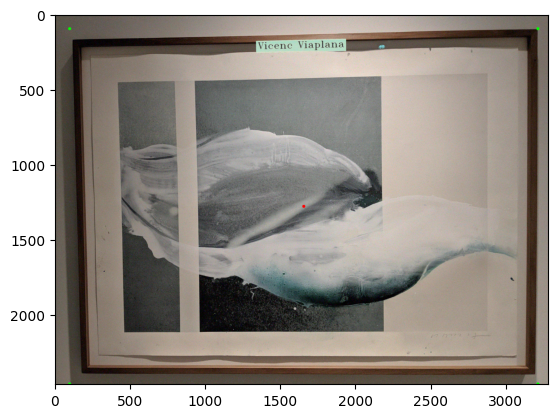

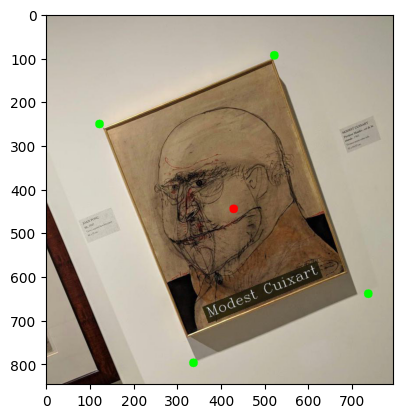

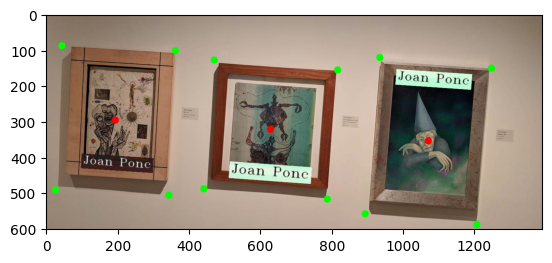

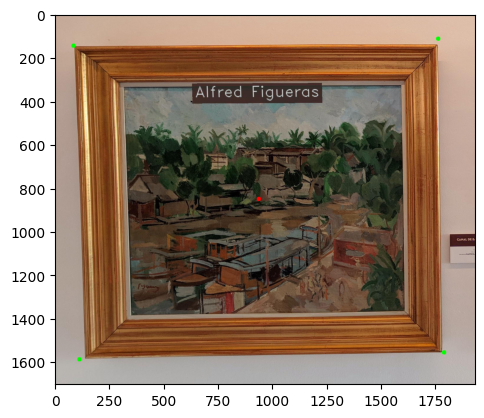

In [15]:
reload(bg_masks)
bg_masks.draw_mask_points_on_image_batch(
    # images=qsd1_w,
    # masks=masks_gen_morphology_qst1_w5,
    n = 6,
    images=qst1_w5[4:10],
    masks=masks_gen_morphology_qst1_w5[4:10],
)

##### [angle, [bbox]]

In [16]:
results

[[[0.0, [(43, 121), (43, 675), (441, 675), (441, 121)]]],
 [[0.07619115125056493, [(0, 71), (0, 2327), (3203, 2330), (3206, 74)]]],
 [[0.08903765872814091, [(49, 146), (47, 1432), (3318, 1439), (3320, 152)]]],
 [[0.6553153069441329, [(67, 115), (74, 726), (527, 721), (520, 109)]],
  [2.7344369021645174, [(827, 88), (858, 757), (1359, 734), (1327, 64)]]],
 [[0.6810470260076871, [(99, 124), (91, 796), (611, 803), (619, 130)]]],
 [[0.42630001664421546, [(54, 116), (39, 2132), (2577, 2151), (2592, 135)]]],
 [[0.0, [(97, 97), (97, 2459), (3211, 2459), (3211, 97)]]],
 [[21.52900688183912, [(122, 251), (337, 797), (737, 639), (522, 94)]]],
 [[2.551095089000937, [(44, 88), (26, 491), (344, 506), (362, 102)]],
  [4.592845330393966, [(471, 128), (442, 488), (788, 517), (817, 156)]],
  [5.359886556955787, [(935, 121), (894, 558), (1207, 588), (1248, 151)]]],
 [[1.071937318329857, [(85, 145), (112, 1588), (1791, 1556), (1764, 113)]]],
 [[0.0, [(54, 121), (54, 390), (299, 390), (299, 121)]]],
 [[0.

### Rotate images and masks

In [17]:
reload(image_utils)
image_utils.rotate_images_and_masks_multiple(
    angle_bboxes=results,
    images=qst1_w5,
    images_files=qst1_w5_files,
    masks=masks_gen_morphology_qst1_w5,
    mssg="Rotating images and masks...",
    output_dir=f"../results/rotated_qst1_w5/"
)

Rotating images and masks...: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]

Saved images to ../results/rotated_qst1_w5/*.jpg
Saved masks to ../results/rotated_qst1_w5/*.png


# TASK 2

### Load rotated images and masks

In [18]:
data_handler = DataHandler()

# Load rotated images:
qst1_w5, qst1_w5_files = data_handler.load_images(
    folder="../results/rotated_qst1_w5/", extension=".jpg", desc="Loading qst1_w5 Data...")

Initialized DataHandler with 2 processes


Loading qst1_w5 Data...: 100%|██████████| 50/50 [00:00<00:00, 83.00it/s] 


../results/rotated_qst1_w5/ read: 50 images


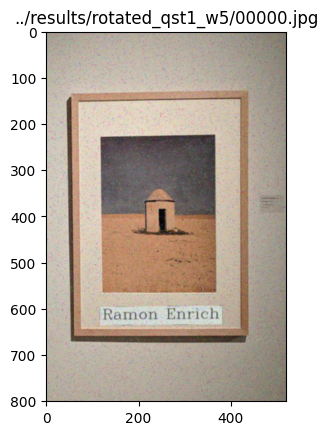

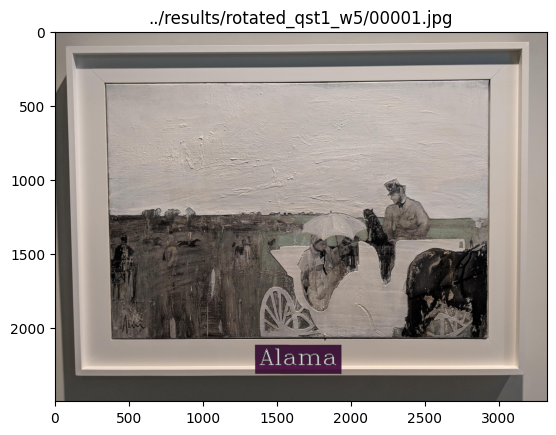

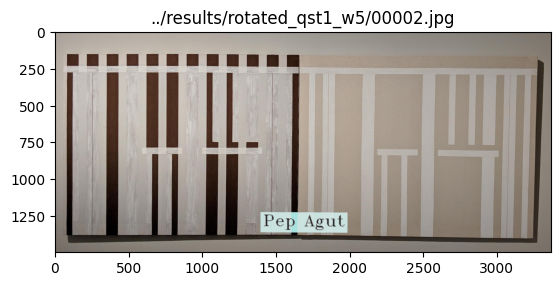

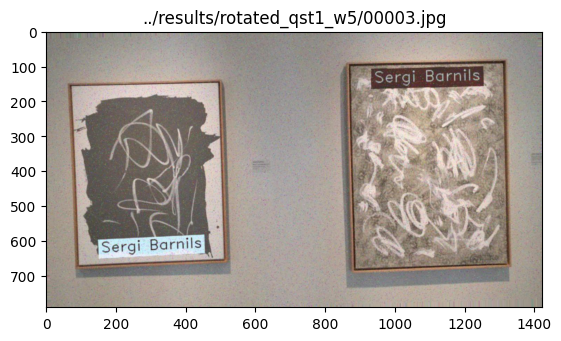

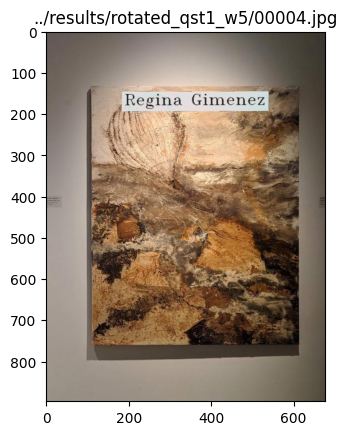

In [19]:
for i, (img, filename) in enumerate(zip(qst1_w5, qst1_w5_files)):
    plt.imshow(img)
    plt.title(filename)
    plt.show()
    if i > 3:
        break

## Masks

In [20]:
from skimage.filters import unsharp_mask
from skimage.exposure import equalize_hist
from skimage.exposure import adjust_gamma, equalize_adapthist
import cv2
from skimage.filters import median
from skimage.morphology import disk

"""
qst1_w5_filt = [adjust_gamma(img, gamma=2, gain=0.6) for img in qst1_w5]
plt.imshow(qst1_w5_filt[26],)
plt.show()
plt.imshow(qst1_w5_filt[29],)
plt.show()
"""

'\nqst1_w5_filt = [adjust_gamma(img, gamma=2, gain=0.6) for img in qst1_w5]\nplt.imshow(qst1_w5_filt[26],)\nplt.show()\nplt.imshow(qst1_w5_filt[29],)\nplt.show()\n'

In [21]:
# load background masks
masks_gen_rotated, masks_gen_rotated_files = data_handler.load_images(
    folder=f"../results/rotated_qst1_w5/",
    extension=".png",
    desc=f"Loading background masks for QSD1-W5..."
)

Loading background masks for QSD1-W5...: 100%|██████████| 50/50 [00:00<00:00, 276.69it/s]


../results/rotated_qst1_w5/ read: 50 images


In [22]:
reload(image_utils)
reload(detect_textbox)

bboxes_qst1_w5, paintings_cropped, mask_text = image_utils.crop_paintings_batch(
    qst1_w5, qst1_w5_files,
    masks_gen_rotated,
    output_dir="../results/cropped_paintings_qst1_w5/",
    extract_text_mask=True,
    flag_mask=True,
)
data_handler.save_object_pickle(bboxes_qst1_w5, "./QSD1/text_boxes.pkl")

Done cropping paintings.
Object saved at ./QSD1/text_boxes.pkl


In [23]:
reload(text_retrieval)
pred_texts_qst1_w5_folder = './results/text/pred_texts_greys_qst1_w5/'
text_retrieval.generate_text_files_multiple(
    "../results/cropped_paintings_qst1_w5/", pred_texts_qst1_w5_folder, greys=True, binary=False)

../results/cropped_paintings_qst1_w5/00000/0.jpg
../results/cropped_paintings_qst1_w5/00001/0.jpg
../results/cropped_paintings_qst1_w5/00002/0.jpg
../results/cropped_paintings_qst1_w5/00003/0.jpg
../results/cropped_paintings_qst1_w5/00003/1.jpg
../results/cropped_paintings_qst1_w5/00003/2.jpg
../results/cropped_paintings_qst1_w5/00004/0.jpg
../results/cropped_paintings_qst1_w5/00005/0.jpg
../results/cropped_paintings_qst1_w5/00006/0.jpg
../results/cropped_paintings_qst1_w5/00007/0.jpg
../results/cropped_paintings_qst1_w5/00008/0.jpg
../results/cropped_paintings_qst1_w5/00008/1.jpg
../results/cropped_paintings_qst1_w5/00008/2.jpg
../results/cropped_paintings_qst1_w5/00009/0.jpg
../results/cropped_paintings_qst1_w5/00010/0.jpg
../results/cropped_paintings_qst1_w5/00011/0.jpg
../results/cropped_paintings_qst1_w5/00012/0.jpg
../results/cropped_paintings_qst1_w5/00013/0.jpg
../results/cropped_paintings_qst1_w5/00014/0.jpg
../results/cropped_paintings_qst1_w5/00014/1.jpg
../results/cropped_p

# ORB

In [24]:
reload(image_features)
db_keypoints_orb, db_features_orb = image_features.orb_batch(
    images=db[:], mssg="Computing ORB from BBDD...")

Computing ORB from BBDD...: 100%|██████████| 287/287 [00:36<00:00,  7.81it/s]


In [25]:
reload(image_features)
keypoints_multiple_orb, features_multiple_orb = image_features.orb_multiple(
    files_dir="../results/cropped_paintings_qst1_w5/", mssg="Computing ORB from QSD...")

Computing ORB from QSD...: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


In [26]:
reload(similarities)
similarity_multiple_qst1_w5_orb = similarities.compute_matches_multiple(
    features_multiple=features_multiple_orb,
    db_features=db_features_orb,
    method="BF",
    similarity_measure="Hamming2",  # this is ignored if method == "FLANN,
    N_PROCESS=1,
)

Computing matches for query image 1...:   0%|          | 0/1 [00:00<?, ?it/s]

Computing matches with BF_matcher...:   0%|          | 0/287 [00:00<?, ?it/s]

Computing matches with BF_matcher...:  59%|█████▉    | 169/287 [00:00<00:00, 1681.91it/s]

                                                                                         
Computing matches for query image 2...:   0%|          | 0/1 [00:00<?, ?it/s]

Computing matches with BF_matcher...:   0%|          | 0/287 [00:00<?, ?it/s]

Computing matches with BF_matcher...:  36%|███▌      | 104/287 [00:00<00:00, 1039.20it/s]

Computing matches with BF_matcher...:  72%|███████▏  | 208/287 [00:00<00:00, 1030.84it/s]

                                                                                         
Computing matches for query image 3...:   0%|          | 0/1 [00:00<?, ?it/s]

Computing matches with BF_matcher...:   0%|          | 0/287 [00:00<?, ?it/s]

Computing matches with BF_matcher...:  90%|████████▉ | 258/287 [00:00<00:

In [27]:
reload(evaluate)
top_1_multiple = evaluate.get_top_k_multiple(
    similarity_multiple_qst1_w5_orb, db_files, k=1, match_threshold=10)

top_5_multiple = evaluate.get_top_k_multiple(
    similarity_multiple_qst1_w5_orb, db_files, k=5, match_threshold=10)

top_10_multiple = evaluate.get_top_k_multiple(
    similarity_multiple_qst1_w5_orb, db_files, k=10, match_threshold=10)

In [28]:
# Top 1:
predicted_results_1_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True,
    name_file="top1",
    path="./results/qst1_w5/orb")

# Top 5:
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True,
    name_file="top5",
    path="./results/qst1_w5/orb")

predicted_results_10_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_10_multiple,
    save=True,
    name_file="top10",
    path="./results/qst1_w5/orb")

Results saved at ./results/qst1_w5/orb/result_top1.pkl
Results saved at ./results/qst1_w5/orb/result_top5.pkl
Results saved at ./results/qst1_w5/orb/result_top10.pkl


### Texture

In [29]:
from tqdm import tqdm
mssg="Histograms of Gradients (HoG) from BBDD..."
db_texture_matrix = [image_features.hog_image(img, image_mask=None) for img in tqdm(db[:], desc=mssg, disable=True)]

In [30]:
feats_multiple_qst1_w5_texture = image_features.hog_multiple(files_dir="../results/cropped_paintings_qst1_w5/", features_filename="qst1_w5_hog")

similarities_multiple_qst1_w5_texture = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qst1_w5_texture,
    db_features=db_texture_matrix,
    similarity_measure="hellinger_kernel",
    n_bins=None,
)

In [31]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarities_multiple_qst1_w5_texture, db_files, k=1, match_threshold=None)
predicted_results_1_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qst1_w5/texture")

# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarities_multiple_qst1_w5_texture, db_files, k=5, match_threshold=None)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qst1_w5/texture")

top_10_multiple = evaluate.get_top_k_multiple(similarities_multiple_qst1_w5_texture, db_files, k=10, match_threshold=None)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_10_multiple,
    save=True,
    name_file="top10",
    path="./results/qst1_w5/texture")

Results saved at ./results/qst1_w5/texture/result_top1.pkl
Results saved at ./results/qst1_w5/texture/result_top5.pkl
Results saved at ./results/qst1_w5/texture/result_top10.pkl


### Text

In [32]:
reload(text_retrieval)
similarity_multiple_qst1_w5_text = text_retrieval.get_distances_text_2paintings(
    files_dir="../results/cropped_paintings_qst1_w5/",
    text_database=db_text,
    dist = 'damerau_levenshtein'
)

In [33]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarity_multiple_qst1_w5_text, db_files, k=1, match_threshold=None)
predicted_results_1_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qst1_w5/text")


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarity_multiple_qst1_w5_text, db_files, k=5, match_threshold=None)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qst1_w5/text")

top_10_multiple = evaluate.get_top_k_multiple(similarity_multiple_qst1_w5_text, db_files, k=10, match_threshold=None)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_10_multiple,
    save=True,
    name_file="top10",
    path="./results/qst1_w5/text")

Results saved at ./results/qst1_w5/text/result_top1.pkl
Results saved at ./results/qst1_w5/text/result_top5.pkl
Results saved at ./results/qst1_w5/text/result_top10.pkl


### Color

In [34]:
feats_multiple_qst1_w5_color = histogram_processing.compute_features_multiple(
    "../results/cropped_paintings_qst1_w5",
    n_levels=5, n_bins=5,
    grayscale = False, RGB = True, CieLab = False, HSV = False, YCbCr = False,
    histogram3d = True,
    use_mask = False,
)

db_feature_matrix_color = histogram_processing.generate_feature_matrix(
    dataset=db[:],
    n_levels=5, n_bins=5,
    grayscale=False,
    RGB=True,
    CieLab=False,
    HSV=False,
    YCbCr=False,
    histogram3d=True,
    mssg="Generating features for BBDD dataset...(with N_PROCESS = {})".format(
        N_PROCESS),
    masks=None,
    N_PROCESS=N_PROCESS,
)

Generating features for BBDD dataset...(with N_PROCESS = 10):  14%|█▍        | 40/287 [00:02<00:12, 19.52it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Generating features for BBDD dataset...(with N_PROCESS = 10): 100%|██████████| 287/287 [00:18<00:00, 15.43it/s]


In [35]:
similarity_multiple_qst1_w5_color = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qst1_w5_color,
    db_features=db_feature_matrix_color,
    similarity_measure="hellinger_kernel",
    n_bins=5
)

In [36]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarity_multiple_qst1_w5_color, db_files, k=1, match_threshold=0)
predicted_results_1_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qst1_w5/color")


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarity_multiple_qst1_w5_color, db_files, k=5, match_threshold=0)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qst1_w5/color")

top_10_multiple = evaluate.get_top_k_multiple(similarity_multiple_qst1_w5_color, db_files, k=10, match_threshold=0)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_10_multiple,
    save=True,
    name_file="top10",
    path="./results/qst1_w5/color")

Results saved at ./results/qst1_w5/color/result_top1.pkl
Results saved at ./results/qst1_w5/color/result_top5.pkl
Results saved at ./results/qst1_w5/color/result_top10.pkl


### Combine descriptors

In [37]:
import copy

def get_max_multiple(list_of_lists_of_arrays):
    max_val = -99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            max_val = np.amax([max_val, list_of_lists_of_arrays[i][j].max()])
    return max_val

def get_min_multiple(list_of_lists_of_arrays):
    min_val = 99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            min_val = np.amin([min_val, list_of_lists_of_arrays[i][j].min()])
    return min_val

def normalize_list_of_list_of_arrays(list_of_lists_of_arrays, min, max):
    list_of_lists_of_arrays1 = copy.deepcopy(list_of_lists_of_arrays)
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays1[i][j] = ( list_of_lists_of_arrays[i][j] - min ) / (max - min)
    return list_of_lists_of_arrays1

def multiply_list_of_list_of_arrays(list_of_lists_of_arrays, other):
    "Multiplication is done in-place"
    
    list_of_lists_of_arrays1 = copy.deepcopy(list_of_lists_of_arrays)
    
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays1[i][j] = list_of_lists_of_arrays[i][j] * other
    return list_of_lists_of_arrays1

def sum_list_of_list_of_arrays(list_of_lists_of_arrays1, list_of_lists_of_arrays2):
    "Summation of list of lists of arrays"
    assert len(list_of_lists_of_arrays1) == len(list_of_lists_of_arrays2)
    res = []
    for i in range(len(list_of_lists_of_arrays1)):
        res_i = []
        for j in range(len(list_of_lists_of_arrays1[i])):
            res_i.append(list_of_lists_of_arrays1[i][j] + list_of_lists_of_arrays2[i][j])
        res.append(res_i)
    return res

In [38]:
# Normalize distances:
texture_max = get_max_multiple(similarities_multiple_qst1_w5_texture)
texture_min = get_min_multiple(similarities_multiple_qst1_w5_texture)
norm_similarity_qst1_w5_texture = normalize_list_of_list_of_arrays(similarities_multiple_qst1_w5_texture, texture_min, texture_max)

color_max = get_max_multiple(similarity_multiple_qst1_w5_color)
color_min = get_min_multiple(similarity_multiple_qst1_w5_color)
norm_similarity_qst1_w5_color = normalize_list_of_list_of_arrays(similarity_multiple_qst1_w5_color, color_min, color_max)

text_max = get_max_multiple(similarity_multiple_qst1_w5_text)
text_min = get_min_multiple(similarity_multiple_qst1_w5_text)
norm_similarity_qst1_w5_text = normalize_list_of_list_of_arrays(similarity_multiple_qst1_w5_text, text_min, text_max)

orb_max = get_max_multiple(similarity_multiple_qst1_w5_orb)
orb_min = get_min_multiple(similarity_multiple_qst1_w5_orb)
norm_similarity_qst1_w5_orb = normalize_list_of_list_of_arrays(similarity_multiple_qst1_w5_orb, orb_min, orb_max)

In [39]:
# Combining four descriptors:
color_weight = 2
texture_weight = 2
text_weight = 1
orb_weight = 9

color_component = multiply_list_of_list_of_arrays(
    norm_similarity_qst1_w5_color,
    color_weight,
)

texture_component = multiply_list_of_list_of_arrays(
    norm_similarity_qst1_w5_texture,
    texture_weight,
)


text_component = multiply_list_of_list_of_arrays(
    norm_similarity_qst1_w5_text,
    text_weight,
)

orb_component = multiply_list_of_list_of_arrays(
    norm_similarity_qst1_w5_orb,
    orb_weight,
)

In [40]:

sim_mat_qst1_w5_2descrip = sum_list_of_list_of_arrays(
    color_component, texture_component
)

sim_mat_qst1_w5_3descrip = sum_list_of_list_of_arrays(
    sim_mat_qst1_w5_2descrip, text_component
)

sim_mat_qst1_w5_4descrip = sum_list_of_list_of_arrays(
    sim_mat_qst1_w5_3descrip, orb_component
)

In [75]:
reload(evaluate)
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(sim_mat_qst1_w5_4descrip, db_files, k=1, match_threshold=0)
predicted_results_1_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qst1_w5/4descrip")


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(sim_mat_qst1_w5_4descrip, db_files, k=5, match_threshold=0)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qst1_w5/4descrip")

top_10_multiple = evaluate.get_top_k_multiple(sim_mat_qst1_w5_4descrip, db_files, k=10, match_threshold=0)
predicted_results_5_qst1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_10_multiple,
    save=True,
    name_file="top10",
    path="./results/qst1_w5/4descrip")

Results saved at ./results/qst1_w5/4descrip/result_top1.pkl
Results saved at ./results/qst1_w5/4descrip/result_top5.pkl
Results saved at ./results/qst1_w5/4descrip/result_top10.pkl


In [76]:
top_10_multiple

[[['../data/BBDD/bbdd_00183.jpg',
   '../data/BBDD/bbdd_00068.jpg',
   '../data/BBDD/bbdd_00085.jpg',
   '../data/BBDD/bbdd_00226.jpg',
   '../data/BBDD/bbdd_00105.jpg',
   '../data/BBDD/bbdd_00008.jpg',
   '../data/BBDD/bbdd_00138.jpg',
   '../data/BBDD/bbdd_00040.jpg',
   '../data/BBDD/bbdd_00186.jpg',
   '../data/BBDD/bbdd_00065.jpg']],
 [['../data/BBDD/bbdd_00018.jpg',
   '../data/BBDD/bbdd_00085.jpg',
   '../data/BBDD/bbdd_00208.jpg',
   '../data/BBDD/bbdd_00049.jpg',
   '../data/BBDD/bbdd_00068.jpg',
   '../data/BBDD/bbdd_00009.jpg',
   '../data/BBDD/bbdd_00059.jpg',
   '../data/BBDD/bbdd_00197.jpg',
   '../data/BBDD/bbdd_00148.jpg',
   '../data/BBDD/bbdd_00213.jpg']],
 [['../data/BBDD/bbdd_00108.jpg',
   '../data/BBDD/bbdd_00165.jpg',
   '../data/BBDD/bbdd_00208.jpg',
   '../data/BBDD/bbdd_00226.jpg',
   '../data/BBDD/bbdd_00085.jpg',
   '../data/BBDD/bbdd_00197.jpg',
   '../data/BBDD/bbdd_00018.jpg',
   '../data/BBDD/bbdd_00073.jpg',
   '../data/BBDD/bbdd_00049.jpg',
   '../dat

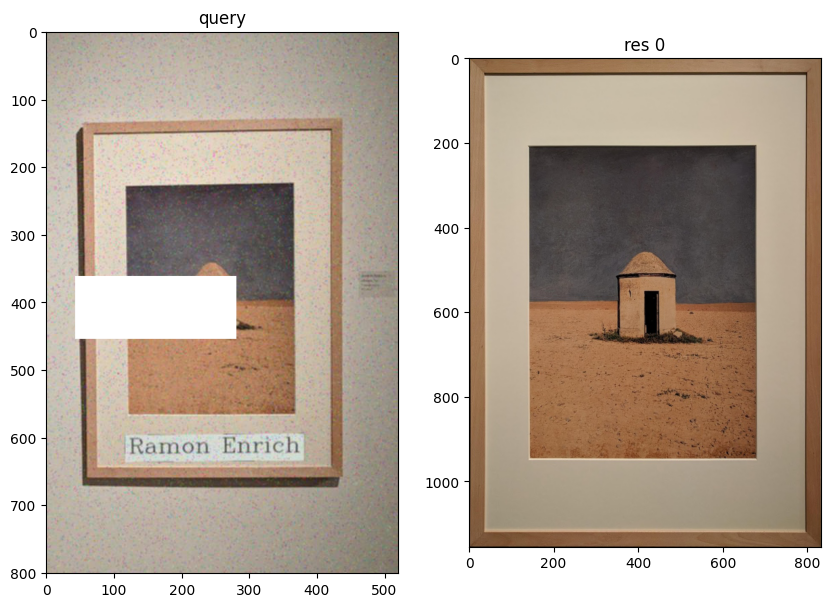

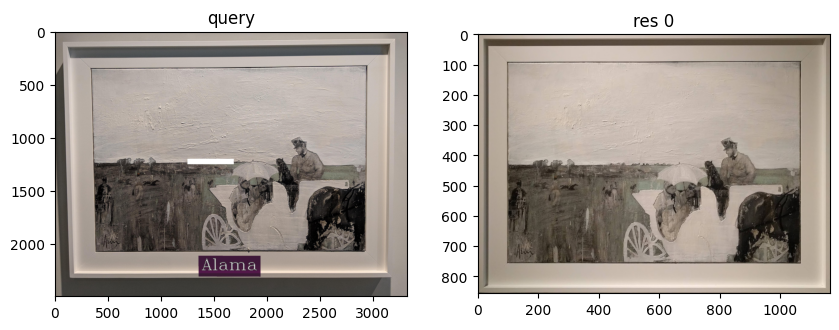

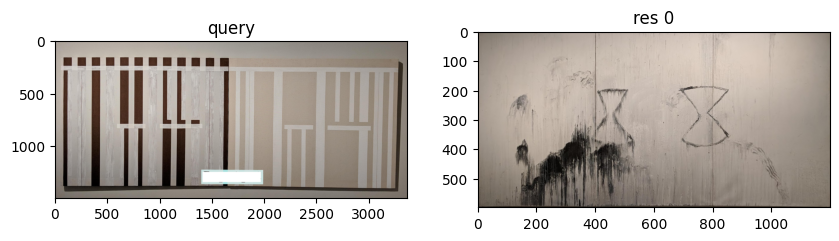

In [77]:
from skimage.io import imread

def plot_image_and_similar_multiple(qs, top_k_qs) -> None:

    for i in range(min(3, len(qs))):
        query = qs[i]

        f, axarr = plt.subplots(1, 1+len(top_k_qs[i]), figsize=(10, 10))
        axarr[0].imshow(query)
        axarr[0].title.set_text("query")
        for j in range(len(top_k_qs[i])):
            res = imread(top_k_qs[i][j][0])
            axarr[1+j].imshow(res)
            axarr[1+j].title.set_text(f"res {j}")
        plt.show()
        
        
plot_image_and_similar_multiple(qst1_w5, top_10_multiple)